# PREDICTING AXL-MEDIATED CANCER PHENOTYPES

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import R2Y_across_components
from msresist.figures.figure1 import pca_dfs
from msresist.figures.figure3 import plotR2YQ2Y, plotActualVsPredicted, plotScoresLoadings, plotClusters, plotPCA 
from msresist.clustering import MassSpecClustering
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing, y_pre, FixColumnLabels
from msresist.distances import DataFrameRipleysK
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

$$ p_{xj} $$

<center>$$   P(m, c_{xj}, p_{xj}) = \sum_{i=c}^{m} {{m}\choose{i}} p_{xj}^i (1 - p_{xj})^{m-i}  $$</center>

$$f(y|N,p) = \frac{N!}{y!(N-y)!}\cdot p^y \cdot (1-p)^{N-y} = {{N}\choose{y}} \cdot p^y \cdot (1-p)^{N-y}$$

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## Check MS Variability Across Replicates

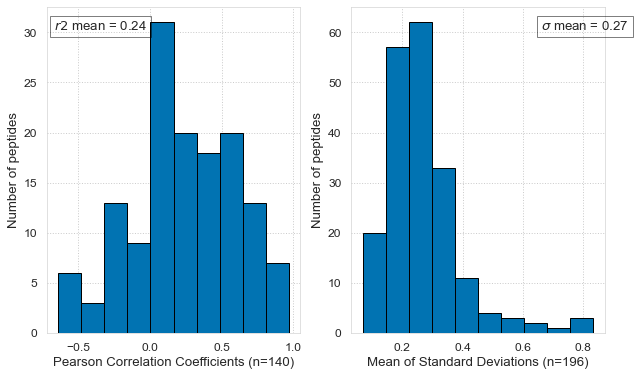

In [3]:
from msresist.figures.figure1 import plotVarReplicates

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
plotVarReplicates(ax, preprocessing(Axlmuts_ErlAF154=True, rawdata=True))

## Import and Preprocess Signaling data

### Phosphorylation measurements:

#### + Erlotinib + AXL-activating Antibody (AF154)

In [4]:
X = preprocessing(Axlmuts_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

all_lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"] 
mut_lines = all_lines[1:]
g_lines = all_lines[2:]

d.index = all_lines

In [5]:
X.shape

(409, 16)

## Cell Phenotypes

### Cell Viability

In [6]:
cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR1_Phase.csv")
cv2 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR2_Phase.csv')
cv3 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')
cv4 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')

In [7]:
itp = 24
ftp = 96

cv = [cv1, cv2, cv3, cv4]
cv= FixColumnLabels(cv)

v_ut = y_pre(cv, "UT", ftp, "Viability", all_lines, itp=itp)
v_e = y_pre(cv, "-E", ftp, "Viability", all_lines, itp=itp)
v_ae = y_pre(cv, "A/E", ftp, "Viability", all_lines, itp=itp)

In [8]:
v_ae

,Lines,Treatment,Viability
0,WT,A/E,4.403463
1,KO,A/E,1.661781
2,KD,A/E,2.430256
3,KI,A/E,3.194731
4,Y634F,A/E,3.000097
5,Y643F,A/E,3.051070
6,Y698F,A/E,3.819585
7,Y726F,A/E,3.599395
8,Y750F,A/E,3.680701
9,Y821F,A/E,2.955662


### Cell Death

In [9]:
red1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR1_RedCount.csv")
red2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR2_RedCount.csv")
red3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR3_RedCount.csv")
red4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR4_RedCount.csv")
red4.columns = red3.columns

In [10]:
for jj in range(1, red1.columns.size):
    red1.iloc[: , jj] /= cv1.iloc[:, jj]
    red2.iloc[: , jj] /= cv2.iloc[:, jj]
    red3.iloc[: , jj] /= cv3.iloc[:, jj]
    red4.iloc[: , jj] /= cv4.iloc[:, jj]


cD = [red1, red2, red3, red4]
cD = FixColumnLabels(cD)
cd_ut = y_pre(cD, "UT", ftp, "Apoptosis", all_lines, itp=itp)
cd_e = y_pre(cD, "-E", ftp, "Apoptosis", all_lines, itp=itp)
cd_ae = y_pre(cD, "A/E", ftp, "Apoptosis", all_lines, itp=itp)

In [11]:
cd_ae

,Lines,Treatment,Apoptosis
0,WT,A/E,3.691883
1,KO,A/E,7.664414
2,KD,A/E,4.564952
3,KI,A/E,4.377763
4,Y634F,A/E,3.669173
5,Y643F,A/E,5.044015
6,Y698F,A/E,3.803003
7,Y726F,A/E,3.277052
8,Y750F,A/E,3.320825
9,Y821F,A/E,2.643537


### Cell Migration

In [12]:
r1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR1_RWD.csv")
r2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR2_RWD.csv")
r3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR3_RWD.csv")
r4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR4_RWD.csv")

In [13]:
ftp = 14
cm = [r1, r2, r3, r4]
m_ut = y_pre(cm, "UT", ftp, "Migration", all_lines)
m_e = y_pre(cm, " E", ftp, "Migration", all_lines)
m_ae = y_pre(cm, "A/E", ftp, "Migration", all_lines)

m_ut.index = v_ut.index
m_e.index = v_e.index
m_ae.index = v_ae.index

In [14]:
m_ae

,Lines,Treatment,Migration
0,WT,A/E,86.079400
1,KO,A/E,63.677377
2,KD,A/E,64.119874
3,KI,A/E,84.625985
4,Y634F,A/E,82.797170
5,Y643F,A/E,84.187636
6,Y698F,A/E,86.223829
7,Y726F,A/E,82.915381
8,Y750F,A/E,78.383198
9,Y821F,A/E,74.318286


### Clustering Effect

In [15]:
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
radius = np.linspace(1, 14.67, 1)
folder = '48hrs'
c = DataFrameRipleysK(folder, mutants, treatments, replicates, radius).reset_index().set_index("Mutant")
c.columns = ["Treatment", "Island"]
c_ut = c[c["Treatment"] == "ut"]
c_ut = c_ut.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_ut.index = all_lines
c_ut = c_ut.reset_index()
c_ut["Treatment"] = "UT"

c_e = c[c["Treatment"] == "e"]
c_e = c_e.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_e.index = all_lines
c_e = c_e.reset_index()
c_e["Treatment"] = "E"

c_ae = c[c["Treatment"] == "ae"]
c_ae = c_ae.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_ae.index = all_lines
c_ae = c_ae.reset_index()
c_ae["Treatment"] = "A/E"

In [16]:
c_ae

,index,Treatment,Island
0,WT,A/E,1.839896
1,KO,A/E,2.965147
2,KD,A/E,3.900568
3,KI,A/E,1.794788
4,Y634F,A/E,2.111434
5,Y643F,A/E,1.905572
6,Y698F,A/E,1.767987
7,Y726F,A/E,1.948927
8,Y750F,A/E,2.888233
9,Y821F,A/E,3.164585


### PCA Analysis

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [18]:
y_ae = pd.concat([v_ae, cd_ae["Apoptosis"], m_ae["Migration"], c_ae["Island"]], axis=1)
y_e =  pd.concat([v_e, cd_e["Apoptosis"], m_e["Migration"], c_ae["Island"]], axis=1)
y_ut =  pd.concat([v_ut, cd_ut["Apoptosis"], m_ut["Migration"], c_ae["Island"]], axis=1)


y_c = pd.concat([y_ut, y_e, y_ae])
y_c.iloc[:, 2:] = StandardScaler().fit_transform(y_c.iloc[:, 2:])
y_c.head()

,Lines,Treatment,Viability,Apoptosis,Migration,Island
0,WT,UT,1.911853,-1.017308,1.687907,-0.833010
1,KO,UT,0.784421,-1.187840,1.264028,0.758900
2,KD,UT,1.369026,-1.218372,1.242270,2.082257
3,KI,UT,1.622194,-1.199679,1.103087,-0.896825
4,Y634F,UT,1.068318,-1.117639,1.453431,-0.448861


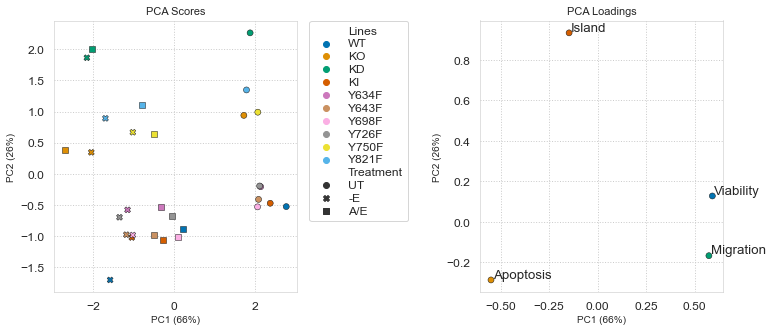

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.75, hspace=None)
plotPCA(ax, y_c, 3, ["Lines", "Treatment"], "Phenotype", hue_scores="Lines", style_scores="Treatment", hue_load="Phenotype", legendOut=True)

#### Build Y Matrix with a Specific Treatment to Model:

With Axl-activating antibody:

In [20]:
y = y_ae.drop("Treatment", axis=1).set_index("Lines")

# 0-. Final X and Y data sets to model

If dropping "WT", run:

In [21]:
# x = X.drop("PC9 A", axis=1)
# d = x.select_dtypes(include=['float64']).T
# i = x.select_dtypes(include=['object'])
# y = y.drop("WT")
# lines = mut_lines

In [22]:
# y = y.drop(["Migration"], axis=1)

Else:

In [23]:
lines = all_lines

# 1-.Fitting PLSR model to the full data set

#### R2Y/Q2Y

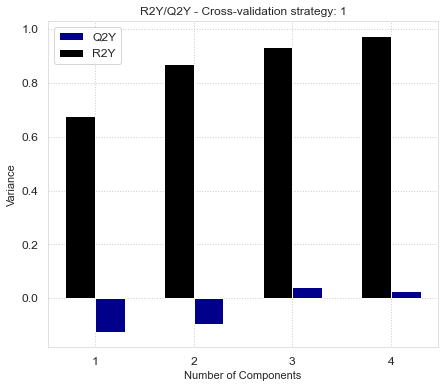

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p1 = PLSRegression(n_components=2)
plotR2YQ2Y(ax, p1, d, y, 1, 5)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Predictions

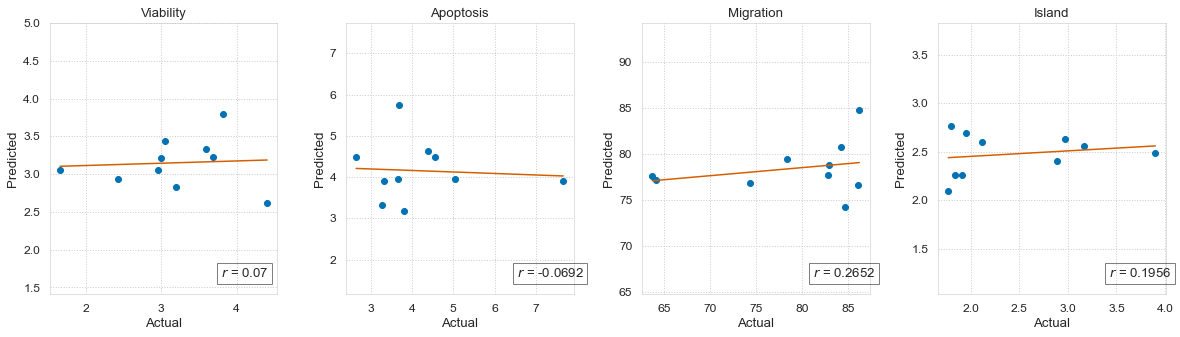

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
p2 = PLSRegression(n_components=2)
plotActualVsPredicted(ax, p2, d, y, 2, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

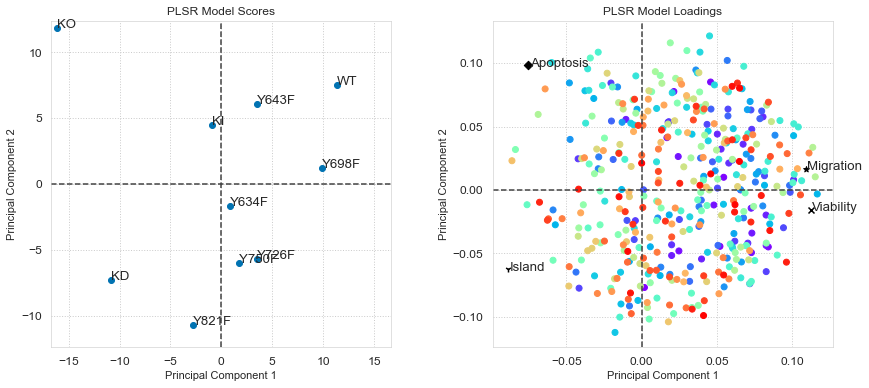

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p1.fit(d, y), d, y, 0, lines, cv=1, data="full", annotate=False)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("plsr_loadings.svg", bbox_inches='tight', format='svg', dpi=1200)

# 2-Clustering and PLSR model

In [27]:
ncl = 7

## 2.1-Standard Clustering methods + PLSR

#### k-means:

In [28]:
from sklearn.cluster import KMeans

labels = KMeans(n_clusters=ncl).fit(d.T).labels_
x_ = X.copy()
x_["Cluster"] = labels
c1 = x_.groupby("Cluster").mean().T

#### SKLEARN's GMM:

In [29]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=ncl).fit(d.T)
# x_ = x.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### POMEGRANATE's GMM:

In [30]:
# from pomegranate import GeneralMixtureModel, NormalDistribution

# gmm = GeneralMixtureModel.from_samples(NormalDistribution, X=d.T, n_components=ncl, n_jobs=-1)
# x_ = x.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### R2Y/Q2Y

In [31]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# p2 = PLSRegression(n_components=2)
# plotR2YQ2Y(ax, p2, c1, y, 1, ncl+1)
# # plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Predictions

In [32]:
# ig, ax = plt.subplots(1, 4, figsize=(20,4))
# fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plotActualVsPredicted(ax, p2, c1, y, 1, y_pred="cross-validation")
# # plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Scores & Loadings

In [33]:
# fig, ax = plt.subplots(1, 2, figsize=(14,6))
# plotScoresLoadings(ax, p2.fit(c1, y), c1, y, ncl, lines, 1)
# fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

## 2.2-Co-clustering and PLSR

## Cross-validation Strategy 1: Leaving one condition out across fixed clusters

In [34]:
# a = np.array([[1,2,3,-14], [5,6,7,-5], [-np.inf, 323, 5, 2]])
# np.amin(a)
# np.amin(np.array(a)[a != -np.inf])

### Fitting PLSR each time

In [35]:
distance_method = "Binomial"
SeqWeight = 50
ncl = 11

MSC = MassSpecClustering(i, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1
                        ).fit(d, y)
c2 = MSC.transform(d)

In [36]:
MSC.wins_

'SeqWins: 300 DataWins: 0 BothWin: 109 MixWin: 0'

#### R2Y/Q2Y

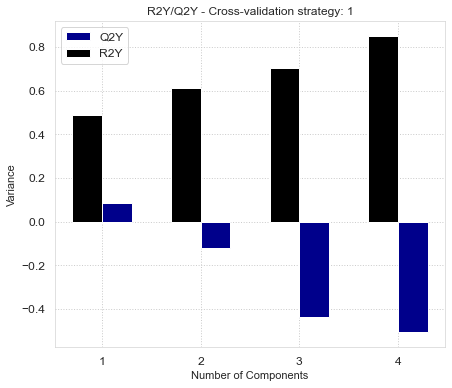

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p3 = PLSRegression(n_components=4, scale=True)
size = ncl + 1
if ncl > 5:
    size = 5
plotR2YQ2Y(ax, p3, c2, y, 1, size)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Predictions

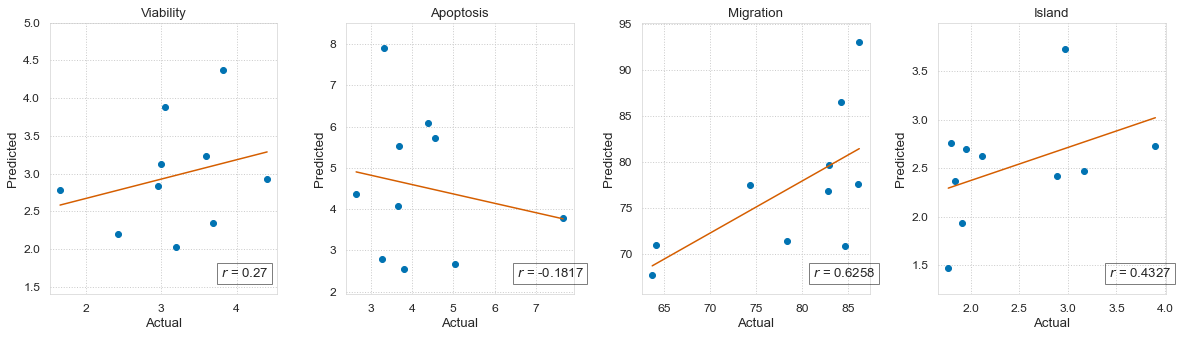

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p3, c2, y, 1, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Scores & Loadings

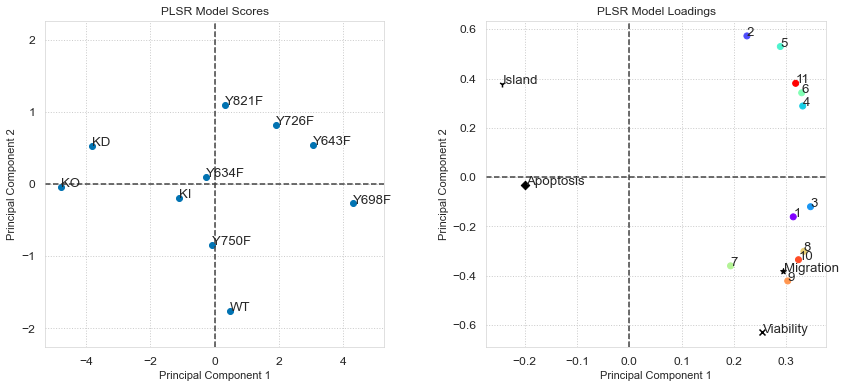

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p3.fit(c2, y), c2, y, ncl, lines, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

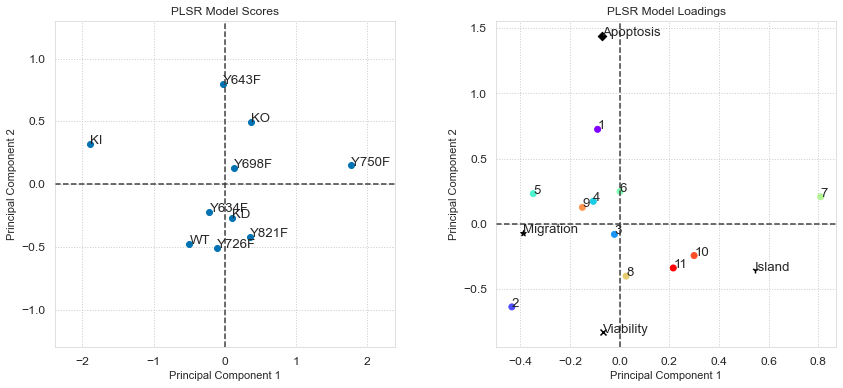

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p3.fit(c2, y), c2, y, ncl, lines, 1, pcX=3, pcY=4)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

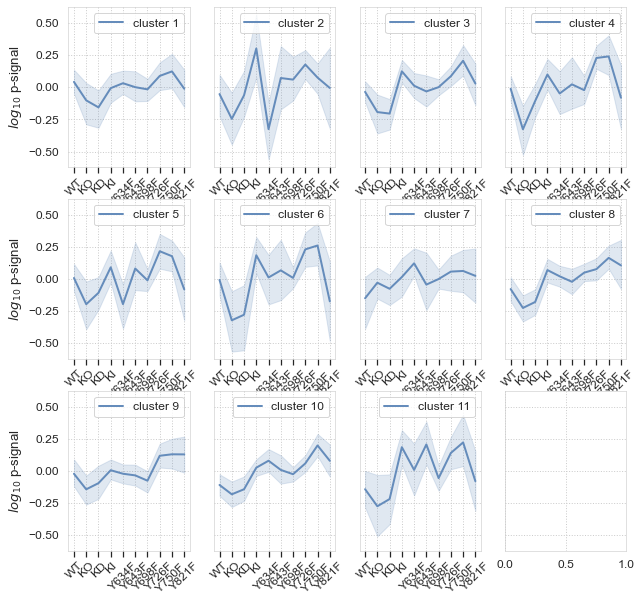

In [41]:
plotClusters(X.copy(), MSC.labels_ + 1, 3, 4, lines, figsize=(10, 10))

In [42]:
# pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

In [43]:
# MSC.clustermembers(X.T)

## 2.3-Random clustering and PLSR

In [44]:
# from random import choices
# x__ = x.copy()
# x__["Cluster"] = choices(list(np.arange(ncl)), k=x.shape[0])
# c3 = x__.groupby("Cluster").mean().T

#### R2Y/Q2Y

In [45]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# p4 = PLSRegression(n_components=2)
# plotR2YQ2Y(ax, p4, c3, y, 1, ncl+1)

#### Predictions

In [46]:
# fig, ax = plt.subplots(1, 4, figsize=(20,4))
# fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plotActualVsPredicted(ax, p4, c3, y, 1, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

## Cross-validation Strategy 2: Across entire pipeline

### Fitting entire model pipeline each time

In [47]:
ncomp = 2

CoCl_plsr = Pipeline([('CoCl', MassSpecClustering(i, 10, SeqWeight=7, distance_method="Binomial", n_runs=1)), ('plsr', PLSRegression(ncomp))])
fit = CoCl_plsr.fit(d, y)
centers = CoCl_plsr.named_steps.CoCl.transform(d)

In [48]:
CoCl_plsr.named_steps.CoCl.wins_

'SeqWins: 184 DataWins: 32 BothWin: 192 MixWin: 1'

#### R2Y/Q2Y

In [49]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# plotR2YQ2Y(ax, CoCl_plsr, d, y, cv=2, b=5)

#### GridSearch

Run:

In [51]:
scores = MSclusPLSR_tuning(d, i, y, "Binomial")
scores = pd.DataFrame(scores)

Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 1
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 1
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluste

In [52]:
scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_MSclustering__SeqWeight,param_MSclustering__ncl,param_plsr__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.339648,0.030665,0.004392,0.000117,0.1,2,1,"{'MSclustering__SeqWeight': 0.1, 'MSclustering...",-15.471340,-9.652732,-15.101270,-27.013609,-5.624627,-5.441948,-10.617797,...,-9.355428,7.775345,139,-5.510309e+00,-6.016313e+00,-4.775659e+00,-3.606190e+00,-6.896846e+00,-6.768171e+00,-4.827671e+00,-7.347514e+00,-8.226922e+00,-5.109265e+00,-5.908486e+00,1.331270e+00
1,1.336662,0.040004,0.004420,0.000095,0.1,2,2,"{'MSclustering__SeqWeight': 0.1, 'MSclustering...",-45.772628,-9.820363,-16.211694,-33.674481,-5.882291,-1.869101,-11.369092,...,-13.505941,14.203683,402,-4.719479e+00,-6.014588e+00,-4.510753e+00,-3.201322e+00,-4.887736e+00,-4.595408e+00,-3.441423e+00,-3.457430e+00,-5.186687e+00,-5.614642e+00,-4.562947e+00,8.983402e-01
2,1.351278,0.038526,0.004382,0.000065,1,2,1,"{'MSclustering__SeqWeight': 1, 'MSclustering__...",-16.238517,-9.791005,-16.480791,-25.372493,-4.842447,-2.224116,-2.846682,...,-8.816752,7.940083,68,-5.235442e+00,-5.982026e+00,-4.728348e+00,-4.020326e+00,-5.769461e+00,-6.183713e+00,-7.990291e+00,-7.632528e+00,-6.055875e+00,-5.391168e+00,-5.898918e+00,1.144815e+00
3,1.371419,0.043584,0.004371,0.000114,1,2,2,"{'MSclustering__SeqWeight': 1, 'MSclustering__...",-15.293455,-10.563551,-16.447323,-47.411984,-4.885711,-10.433979,-7.147883,...,-11.756290,12.955735,341,-5.013589e+00,-5.294109e+00,-5.458812e+00,-3.606314e+00,-5.278709e+00,-4.139428e+00,-6.049874e+00,-3.033262e+00,-5.462377e+00,-4.425695e+00,-4.776217e+00,8.983842e-01
4,1.379183,0.044930,0.004345,0.000072,3,2,1,"{'MSclustering__SeqWeight': 3, 'MSclustering__...",-4.031191,-10.388768,-17.171933,-27.557887,-6.711325,-2.677407,-8.894080,...,-9.117459,8.062383,106,-5.035287e+00,-6.304820e+00,-5.830843e+00,-3.638248e+00,-7.132020e+00,-5.491899e+00,-5.851528e+00,-5.553345e+00,-7.819829e+00,-6.393496e+00,-5.905131e+00,1.084798e+00
5,1.366625,0.035529,0.004348,0.000153,3,2,2,"{'MSclustering__SeqWeight': 3, 'MSclustering__...",-12.869837,-7.618804,-12.064609,-32.911968,-6.501046,-6.213712,-18.647137,...,-10.192674,9.277222,247,-5.489636e+00,-4.223000e+00,-5.022338e+00,-3.497819e+00,-6.057603e+00,-4.931235e+00,-3.345323e+00,-5.479770e+00,-6.380449e+00,-5.414116e+00,-4.984129e+00,9.626277e-01
6,1.368679,0.039450,0.004241,0.000047,5,2,1,"{'MSclustering__SeqWeight': 5, 'MSclustering__...",-11.391059,-9.317194,-14.207841,-34.179721,-5.114012,-4.073894,-5.577551,...,-10.133140,9.543922,235,-6.149141e+00,-5.806983e+00,-5.757881e+00,-3.499896e+00,-5.562956e+00,-6.871990e+00,-6.607984e+00,-7.086294e+00,-6.670256e+00,-6.525945e+00,-6.053932e+00,9.780831e-01
7,1.375186,0.038670,0.004231,0.000018,5,2,2,"{'MSclustering__SeqWeight': 5, 'MSclustering__...",-5.650423,-7.612766,-16.085615,-22.548057,-0.733974,-3.923779,-14.805707,...,-9.703659,8.642279,196,-4.957244e+00,-5.711926e+00,-4.930548e+00,-2.568988e+00,-3.979475e+00,-3.967175e+00,-4.521726e+00,-5.265731e+00,-5.981396e+00,-5.394308e+00,-4.727852e+00,9.596268e-01
8,1.383045,0.039030,0.004247,0.000059,7,2,1,"{'MSclustering__SeqWeight': 7, 'MSclustering__...",-11.636510,-10.004871,-15.158032,-27.607913,-6.602098,-3.844322,-7.206706,...,-9.121506,7.596885,108,-5.922078e+00,-6.187370e+00,-5.410282e+00,-3.806547e+00,-6.128030e+00,-6.758969e+00,-6.008979e+00,-6.720570e+00,-6.304412e+00,-5.657722e+00,-5.890496e+00,8.001139e-01
9,1.444104,0.045430,0.004542,0.000117,7,2,2,"{'MSclustering__SeqWeight': 7, 'MSclustering__...",-14.789101,-8.595429,-7.304760,-26.678933,-6.979743,-6.907103,-10.290627,...,

In [55]:
scores_ = scores[["rank_test_score", "param_MSclustering__SeqWeight", "param_MSclustering__ncl", "param_plsr__n_components", "mean_test_score", "std_test_score"]].sort_values(by="mean_test_score", ascending=False)

In [57]:
create_download_link(scores_, "08042020AXL_ABC_Binomial_withWT_fullGrid.csv")

#### Measured vs Predicted

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,4))
plotActualVsPredicted(ax, CoCl_plsr, d, y, 2)

#### Scores & Loadings

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, y, ncl, lines, 2)

In [ ]:
clustermembers = CoCl_plsr.named_steps.CoCl.clustermembers(X.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")

\[ P(m, c_xj, p_xj) = \dbinom{m}{i} p_xj^i(1-p_xj)^{m-i}\]